#  ATOC5860 Application Lab #6 - cluster_mesa_data
##### Written by Prof. Kay (CU), Dr. Middlemas (formerly CU, now PricewaterhouseCoopers), Genevieve Clow (CU)
##### last updated April 9, 2024 - works with environment culabenv2024


### LEARNING GOALS:
1. Apply k-means clustering as an example of unsupervised (grouping events into different categories) machine learning. Build understanding of the technique with a familiar dataset (local weather observations). 
2. Assess the limits and applicability of K-means clustering to detect seasons in Boulder, Colorado. How do the "month-based seasons" (i.e., based on the calendar month - winter, summer, spring, fall) differ from the "data-based" seasons (i.e., based on the k-means clustering)?  What is the sensitivity of the clustering results to standardization, changing the variables used for the clustering (also called “features”), the number of clusters (4 vs. 3), and the time of day used (default 17 UTC)? How might you use the results of these analysis if you were an emergency planner or an energy resource planner?
3. Build skills for data munging and analysis: a) Assess munging strategies for replacing missing data, b) Contrast a pandas dataframe with a numpy data array, c) Identify strategies for writing code that is flexible/adaptable.
 

### DATA and UNDERLYING SCIENCE MOTIVATION: 

Here, we will use [K-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) to classify weather data into different clusters. Why would we cluster weather observations?  We already know which observations are in which season by looking at the date -- but that is the "month-based season". We all know that a day in April sometimes feels like summer and sometimes feels like winter.  We often have multiple seasons in a single week... So this could be quite fun to see how the algorithm decides how to cluster our data and assign each day to a "data-based season". :)  Do you think the "month-based seasons" and "data-based seasons" will be the same? We will soon see!  <br>

We will be working with weather data from the [NCAR Mesa Laboratory in Boulder, Colorado](https://en.wikipedia.org/wiki/Mesa_Laboratory). We'll call this dataset the "Mesa dataset". The data go from 2016-2021.  Prof. Kay's munging code is up [on github](https://github.com/jenkayco/ATOC4500_Spring2022/tree/main/mesadata_process).  Information on the site and the instruments is [here](https://www.eol.ucar.edu/content/ncar-foothills-lab-weather-station-information).  Real-time data from the site is [here](https://archive.eol.ucar.edu/cgi-bin/weather.cgi?site=ml&period=5-minute&fields=tdry&fields=rh&fields=cpres0&fields=wspd&fields=wdir&fields=raina&units=english). An example of what some of the munging might look like for this dataset is [here](https://ncar.github.io/esds/posts/2021/weather-station-data-preprocess/).  *Note: Each year in this dataset has 365 days.  Leap year data (i.e., Feb. 29 data for 2016 and 2020 have been excluded.)* <br>

**Questions to guide your analysis** 

1) What must be done to your data before you can apply k-means clustering to it?  Suggested steps: Read in your data. Look at your data as a pandas dataframe. Add month-based season as a variable. Only select the data at 17 UTC (10am/11am Mountain time) Look at your dataframe again. Convert from a pandas dataframe to a numpy array. Look at your data again! Replace Missing Data. Discuss strategies for replacing missing data.  Look your data again!, Recale your data to have unit variance.  Discuss why you should use data with unit variance. Look at your data again!

2) Use K-means clustering to divide the data into 4 clusters.  Start with 4 clusters.  Cluster the data at 17 UTC (mid-day in Colorado).  What is the seasonal occurrence of the 4 clusters?  Do the 4 clusters correspond to Fall, Winter, Spring, and Summer?  Why or why not?!

3) Visualize your results:  Plot cluster assignments by calendar day.  Plot cluster assignments of the data in x-y plots. Plot histograms of the assigned clusters in the month-based seasons.  What have you learned about the data-based seasons assigned by the k-means clustering algorithm?  How do those seasons differ from the traditional month-based seasons?  Based on 2D and 3D scatter plots of the cluster centers and the data – Which weather variables help (or NOT help) define the clusters?

4) Make a copy of this notebook and rename it. Re-run the analysis.  But now use three clusters instead of four clusters. Compare your cluster analyses for 4 clusters and 3 clusters.  Do the results for 4 clusters or 3 clusters make more sense to you based on your analysis and also your experience living in Boulder, Colorado?  Which number of clusters provides the best fit to the data?

5) Time permitting: After you have explored the results and understand them for 3 vs. 4 clusters.  Make a copy of this notebook, and re-run the analysis using a different time of day.  Instead of 17 UTC (10am/11am Mountain time), try 12 UTC or 20 UTC.  Does it affect your results.

**STEP 1: Import packages and functions we will use**

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy.signal as sig
from matplotlib.gridspec import GridSpec
import timeit
import scipy.io as sio
import datetime as dt
import pandas as pd
from scipy.cluster.vq import vq, kmeans, whiten

**STEP 2: Read in the Data and Look At It**

In [27]:
### Read in your data
df = pd.read_csv("NCAR_mesa_data_2016-2021_withmissing.csv")
### Preview the values in the data frame by printing it
print(df.shape)
### Print the Shape of the data frame
df

(52560, 10)


,day,hour_UTC,pres_mb,tdry_degC,rh_percent,wdir,wspd_m_per_s,wspdmax_m_per_s,raina_event_mm,year
0,2016-01-01,0.0,817.400024,-7.7,72.099998,316.0,2.2,3.0,0.0,2016
1,2016-01-01,1.0,817.599976,-8.1,74.699997,327.0,0.9,1.3,0.0,2016
2,2016-01-01,2.0,818.099976,-8.0,70.500000,227.0,1.7,2.8,0.0,2016
3,2016-01-01,3.0,818.500000,-8.1,69.599998,220.0,1.6,2.9,0.0,2016
4,2016-01-01,4.0,818.799988,-10.0,70.900002,336.0,0.9,2.2,0.0,2016
...,...,...,...,...,...,...,...,...,...,...
52555,2021-12-31,19.0,794.200012,-2.3,77.500000,154.0,6.5,9.6,0.0,2021
52556,2021-12-31,20.0,793.599976,-2.6,77.500000,172.0,7.5,10.2,0.0,2021
52557,2021-12-31,21.0,793.500000,-2.9,78.199997,171.0,5.2,8.5,0.0,2021
52558,2021-12-31,22.0,793.799988,-2.9,84.900002,125.0,2.5,4.6,0.0,2021


In [3]:
### Check out the available days in this dataset
print(f'How many days are in this dataset?: {df.day.nunique()}')
print(f'nyrs*ndays={6*365}')
## check that the day format is a readable date
print(df['day'])

How many days are in this dataset?: 2190
nyrs*ndays=2190
0        2016-01-01
1        2016-01-01
2        2016-01-01
3        2016-01-01
4        2016-01-01
            ...    
52555    2021-12-31
52556    2021-12-31
52557    2021-12-31
52558    2021-12-31
52559    2021-12-31
Name: day, Length: 52560, dtype: object


**STEP 3: Add the month-based season as a variable to your data frame**

In [60]:
## add a new variable called "season" to the dataframe df
## this variable contains the season defined traditionally based on the month: 
## DJF=winter, MAM=spring, JJA=summer, SON=fall

## use a dictionary to define seasons from months
### define the seasons as DJF=winter=1, MAM=spring=2, JJA=summer=3, SON=fall=4

seasons = {(1, 12, 2): 1, (3, 4, 5): 2, (6, 7, 8): 3, (9, 10, 11): 4}
## define a function to assign seasons to months using the dictionary
def season(ser):
    for k in seasons.keys():
        if ser in k:
            return seasons[k]

## apply the function season to one time in my dataset as a sanity check
#print(df['day'][5000].month)
#print(season(df['day'][5000].month))

## apply it to all times in my dataset - check
#for month in pd.DatetimeIndex(df['day']).month[-5000:-4890]:
#  print(season(month))

## apply the function season to all times in my dataset
df['season']=[season(month) for month in pd.DatetimeIndex(df['day']).month]

#check random value values
#df['season'][5000]

## check the data frame to see if there is a new variable called "season"
df

,day,hour_UTC,pres_mb,tdry_degC,rh_percent,wdir,wspd_m_per_s,wspdmax_m_per_s,raina_event_mm,year,season
0,2016-01-01,0.0,817.400024,-7.7,72.099998,316.0,2.2,3.0,0.0,2016,1
1,2016-01-01,1.0,817.599976,-8.1,74.699997,327.0,0.9,1.3,0.0,2016,1
2,2016-01-01,2.0,818.099976,-8.0,70.500000,227.0,1.7,2.8,0.0,2016,1
3,2016-01-01,3.0,818.500000,-8.1,69.599998,220.0,1.6,2.9,0.0,2016,1
4,2016-01-01,4.0,818.799988,-10.0,70.900002,336.0,0.9,2.2,0.0,2016,1
...,...,...,...,...,...,...,...,...,...,...,...
52555,2021-12-31,19.0,794.200012,-2.3,77.500000,154.0,6.5,9.6,0.0,2021,1
52556,2021-12-31,20.0,793.599976,-2.6,77.500000,172.0,7.5,10.2,0.0,2021,1
52557,2021-12-31,21.0,793.500000,-2.9,78.199997,171.0,5.2,8.5,0.0,2021,1
52558,2021-12-31,22.0,793.799988,-2.9,84.900002,125.0,2.5,4.6,0.0,2021,1


**STEP 4: Select Data To Use, Convert data into a Numpy Array, Look at data again!**

In [61]:
#### select the time

##Only select a certain time ##Note: time is in UTC.
## Could try 17 UTC (10/11 am in Denver) or 4 UTC (9/10 pm in Denver)
selectedhourUTC = 2 ## added so that there is a variable that sets the selected hour for the rest of the notebook.
selectdf = df[df.hour_UTC == selectedhourUTC] ## 
print(len(selectdf))

### tinker later (code that you may want to "borrow" later in this notebook)
#selectdf = df # try selecting all data instead of just noon data

selectdf

2190


,day,hour_UTC,pres_mb,tdry_degC,rh_percent,wdir,wspd_m_per_s,wspdmax_m_per_s,raina_event_mm,year,season
2,2016-01-01,2.0,818.099976,-8.0,70.500000,227.0,1.7,2.8,0.0,2016,1
26,2016-01-02,2.0,816.900024,-0.4,24.000000,238.0,2.1,4.6,0.0,2016,1
50,2016-01-03,2.0,815.900024,2.5,17.700001,313.0,1.5,2.0,0.0,2016,1
74,2016-01-04,2.0,815.099976,4.7,29.900000,321.0,1.1,1.6,0.0,2016,1
98,2016-01-05,2.0,807.299988,3.7,39.900002,133.0,1.4,2.4,0.0,2016,1
...,...,...,...,...,...,...,...,...,...,...,...
52442,2021-12-27,2.0,798.400024,1.6,32.599998,277.0,4.1,9.2,0.0,2021,1
52466,2021-12-28,2.0,790.799988,2.1,35.000000,270.0,1.1,1.6,0.0,2021,1
52490,2021-12-29,2.0,795.799988,-4.0,33.400002,112.0,1.8,4.2,0.0,2021,1
52514,2021-12-30,2.0,799.200012,-5.3,41.599998,0.0,1.9,2.6,0.0,2021,1


In [62]:
## Select variables of interest. Aside variables are called "features" by some in the ML world.
included_cols = ['pres_mb','tdry_degC','rh_percent','wdir','wspd_m_per_s','wspdmax_m_per_s','raina_event_mm'] 

## convert to a numpy array for model input and leave out the time dimensions day & hour, and wind directions.
data = selectdf.loc[:, selectdf.columns.isin(list(included_cols))].to_numpy()

## check the shape of your data -- should be (6*365,7) (nyrs*ndays, variable)
print(f'Your data are now 2190 observations over 7 variables: {np.shape(data)}')
print(data.shape)

Your data are now 2190 observations over 7 variables: (2190, 7)
(2190, 7)


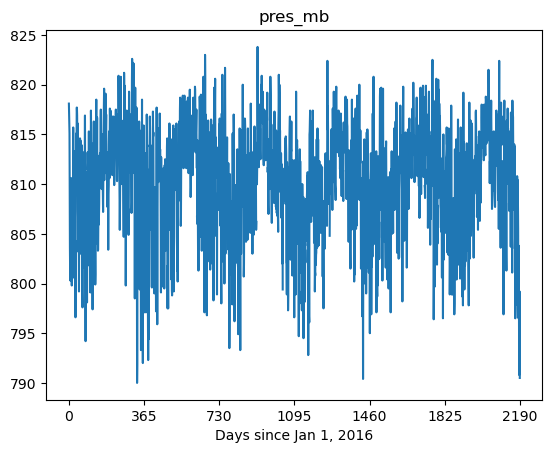

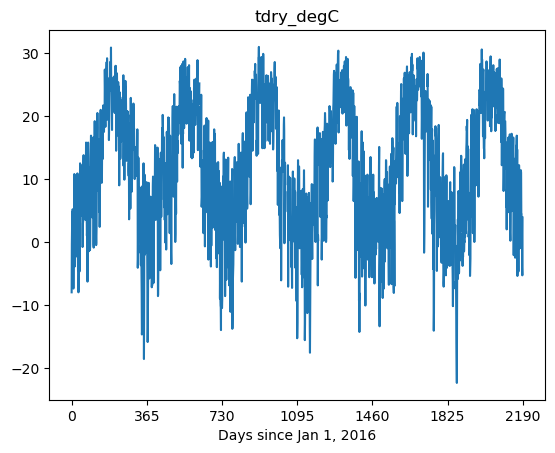

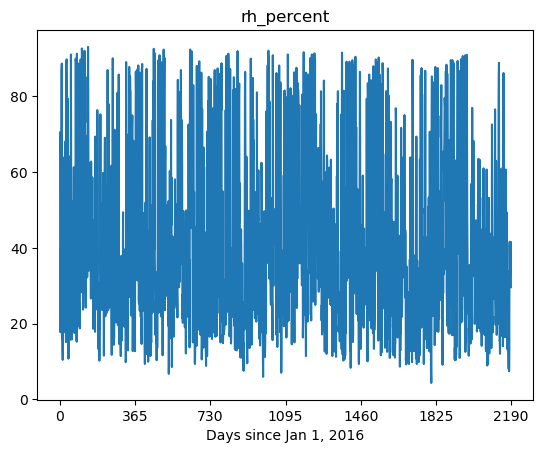

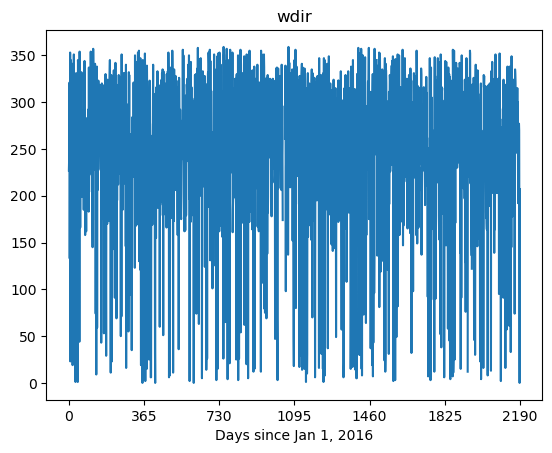

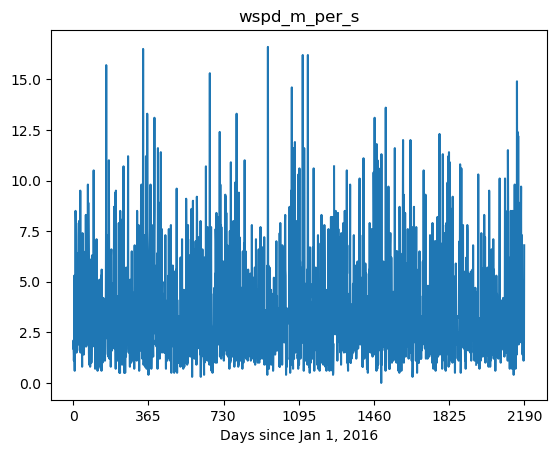

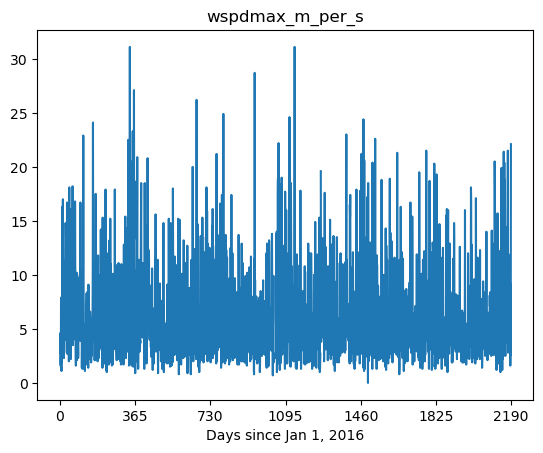

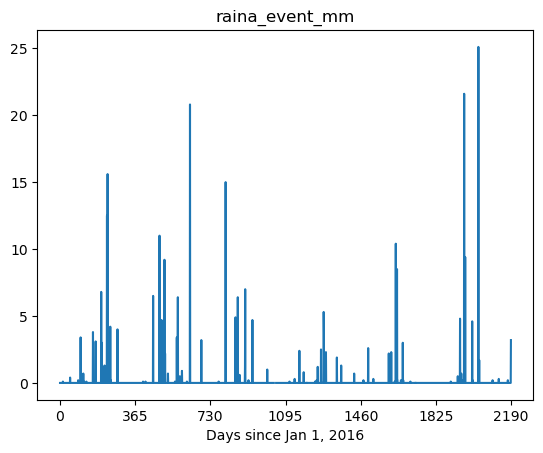

In [63]:
### option to check out quick plots of your data...
### say yes first time through - double check your input, ALWAYS.
quickplot = 'yes'
if quickplot == 'yes':
  ## Quick plots of your data
  for i in np.arange(0,np.shape(data)[1]):
    plt.plot(data[:,i]);
    plt.title(included_cols[i])
    plt.xticks(ticks=np.arange(0,len(data)+365,365)) ###
    plt.xlabel('Days since Jan 1, 2016')
    plt.show()

**STEP 5: Replace missing data.**  There are missing values in the Mesa dataset. Before you use the data in the k-means clustering algorithm - you need to replace missing data with a real value.  There are a couple of options below for how to do this.  If you would like to code it up, you are also welcome to experiment with other options (e.g., interpolate, randomly select values).  Adding to the ATOC5860 code repository welcome!

In [64]:
## copy the data array into a new array without missing values called (data_nomissing)
data_nomissing = data.copy();
print(data_nomissing.shape)

option_missing = 'option1'

##### OPTION #1 - replace the NaN data with the mean value for that season.  Simple!
if option_missing == 'option1':
    
    season = selectdf['season'];
    #print(len(season))

    ## this is the actual season from the definition in the season dictionary above
    season_idx = df['season'][df.hour_UTC==4].to_numpy()
    #print(season_idx.shape)
    ## find all of the days in winter, i.e., where season_idx=1
    winteridx = np.nonzero(np.where(season_idx==1,1,0))
    ## loop over variables
    for i in np.arange(0,len(included_cols)):
        data_nomissing[winteridx,i] = np.where(np.isnan(data[winteridx,i])==True,np.nanmean(data[winteridx,i]),data[winteridx,i])
    ## find all of the days in spring, i.e., where season_idx=2
    springidx = np.nonzero(np.where(season_idx==2,1,0))
    ## loop over variables
    for i in np.arange(0,len(included_cols)):
        data_nomissing[springidx,i] = np.where(np.isnan(data[springidx,i])==True,np.nanmean(data[springidx,i]),data[springidx,i])
    ## find all of the days in summer, i.e., where season_idx=3
    summeridx = np.nonzero(np.where(season_idx==3,1,0))
    ## loop over variables
    for i in np.arange(0,len(included_cols)):
        data_nomissing[summeridx,i] = np.where(np.isnan(data[summeridx,i])==True,np.nanmean(data[summeridx,i]),data[summeridx,i])
    ## find all of the days in fall, i.e., where season_idx=4
    fallidx = np.nonzero(np.where(season_idx==4,1,0))
    ## loop over variables
    for i in np.arange(0,len(included_cols)):
        data_nomissing[fallidx,i]=np.where(np.isnan(data[fallidx,i])==True,np.nanmean(data[fallidx,i]),data[fallidx,i])


(2190, 7)


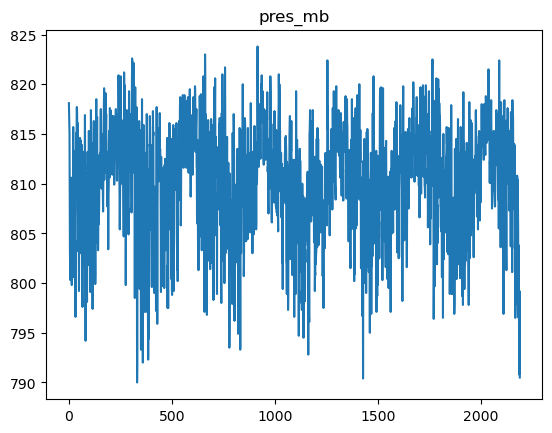

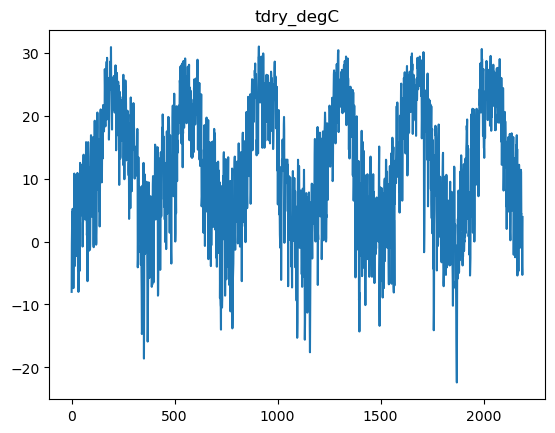

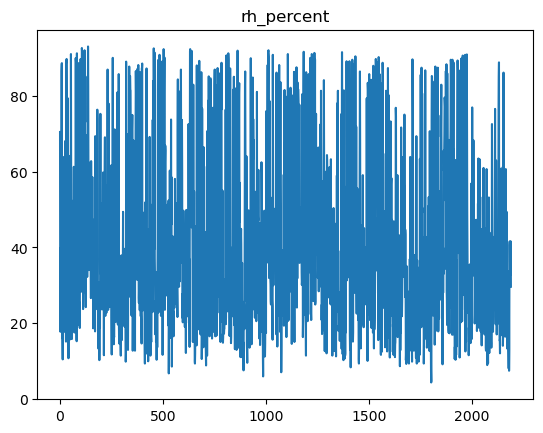

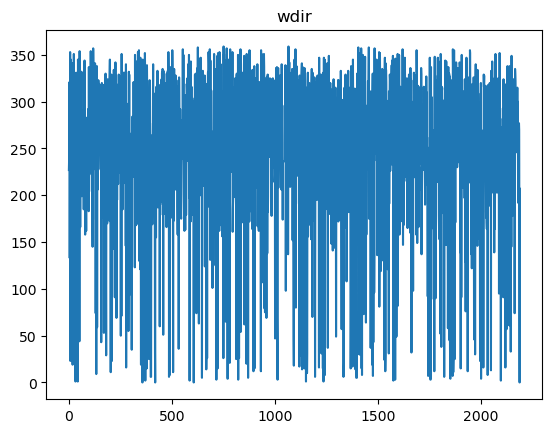

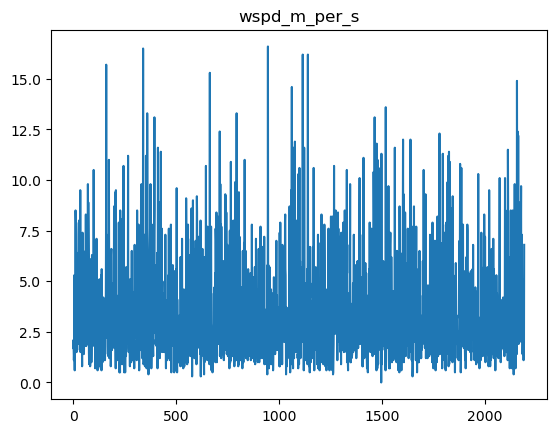

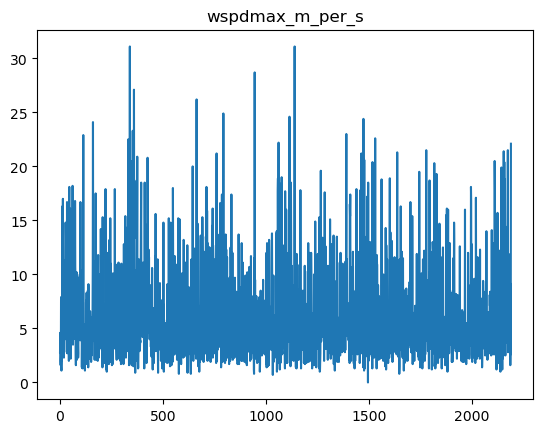

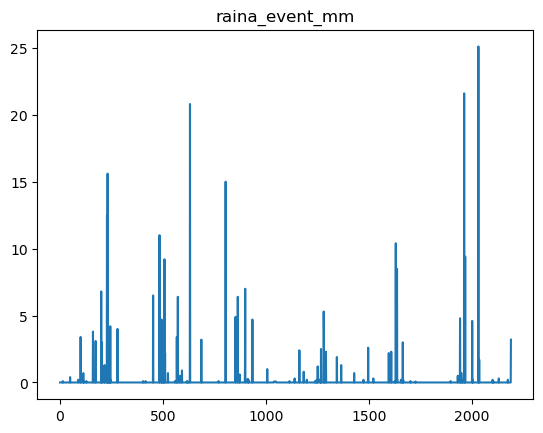

take the mean of the variable data exluding missing data: 159.06839682768475
take the mean of the variable data: nan
take the mean of the variable data_nomissing: 159.02807083494164


In [65]:
##### plot your data to see what they look like after you have dealt with nan (i.e., missing data)
quickplot = 'yes'
if quickplot == 'yes':
  ## Quick plots of your data
  for i in np.arange(0,np.shape(data_nomissing)[1]):
    plt.plot(data_nomissing[:,i]);
    plt.title(included_cols[i])
    plt.show()

### if np.mean for data_nomissing is a real value - we have removed all the missing values!
print(f'take the mean of the variable data exluding missing data: {np.nanmean(data)}')
print(f'take the mean of the variable data: {np.mean(data)}')
print(f'take the mean of the variable data_nomissing: {np.mean(data_nomissing)}')

**STEP 6: Recale your data to have unit variance**. *Why? Since clustering among features depends on distance, we need to scale all of our features so that all features have equal variance. We don't want the clustering to be dominated by the feature with the largest variance...*

*"Before running k-means, it is beneficial to rescale each feature dimension of the observation 
set by its standard deviation (i.e. “whiten” it - as in “white noise” where each frequency has equal power). 
Each feature is divided by its standard deviation across all observations to give it unit variance."*
 https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.whiten.html

In [66]:
scaled_data = whiten(data_nomissing) # sci-kit learn's function to standardize data in the clustering toolbox
#scaled_data = data.copy() # uncomment to NOT whiten, but still enable this notebook to run without modifications

## Check that you end up with the same shape as the original data...
print(f'LOOK AT YOUR DATA: shape should be (days, variable), more specifically (366,8): {np.shape(scaled_data)}')

print('mean of each variable')
print(np.mean(scaled_data,axis=0))
print('standard deviation of each variable')
print(np.std(scaled_data,axis=0))

### print the type of scaled_data
print(type(scaled_data))

LOOK AT YOUR DATA: shape should be (days, variable), more specifically (366,8): (2190, 7)
mean of each variable
[1.48105359e+02 1.17074575e+00 1.79999211e+00 2.93030322e+00
 1.42987693e+00 1.45212208e+00 1.16591233e-01]
standard deviation of each variable
[1. 1. 1. 1. 1. 1. 1.]
<class 'numpy.ndarray'>


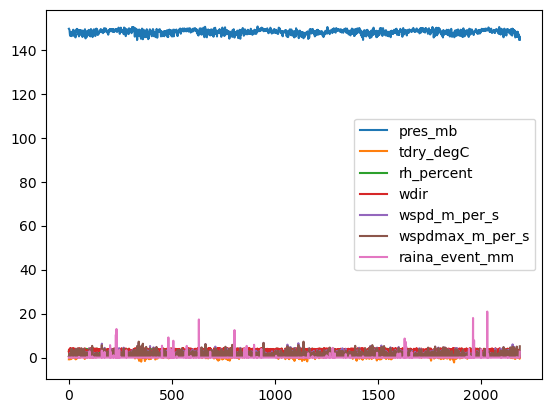

In [67]:
## check out quick plots of scaled_data... always take this option.
## note: we did not remove the mean...
quickplot = 'yes'
if quickplot == 'yes':
  ## Quick plots of your data
  for i in np.arange(0,np.shape(scaled_data)[1]):
    plt.plot(scaled_data[:,i],label=included_cols[i]);
    ## check what happens when you uncomment the two lines below
    #plt.title(included_cols[i])
    #plt.show()
  plt.legend()

**STEP 7: Try making an elbow plot to assess the ideal number of clusters to pick**

Aside: Code contributed by Genevieve Clow.
Note: there are other methods to assess the ideal number of clusters. Such as the gap statistic - Maybe you want to try to code that up?? (https://github.com/jmmaloney3/gapstat)

In [68]:
from sklearn.cluster import KMeans

In [69]:
df_kmeans = df[df['hour_UTC'] == 17][['pres_mb', 'tdry_degC', 'rh_percent', 'wdir',
                                      'wspd_m_per_s', 'wspdmax_m_per_s', 'raina_event_mm',]]
df_kmeans = df_kmeans.dropna()

In [70]:
distortions = []
K = range(2,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_kmeans.to_numpy())
    distortions.append(kmeanModel.inertia_)
    # the inertia parameter is the Sum of squared distances of samples to their closest cluster center, 
    # weighted by the sample weights if provided.

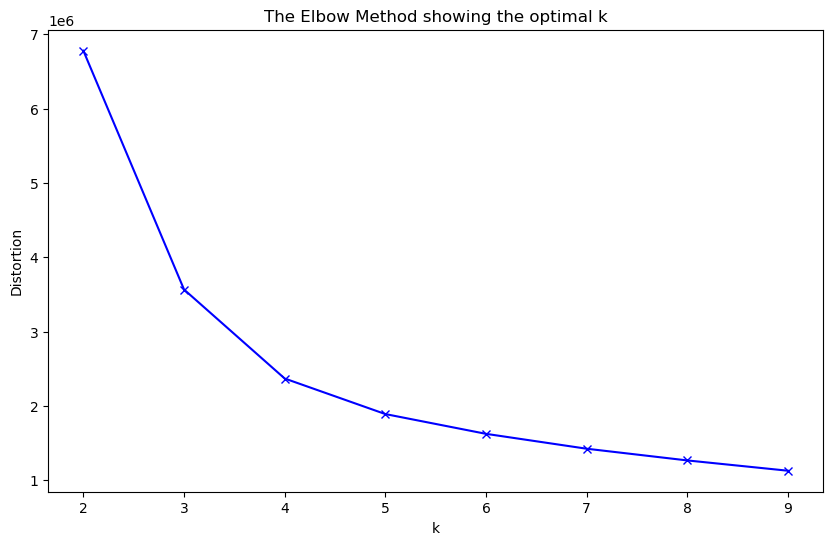

In [71]:
plt.figure(figsize=(10,6));
plt.plot(K, distortions, 'bx-');
plt.xlabel('k');
plt.ylabel('Distortion');
plt.title('The Elbow Method showing the optimal k');

**STEP 8: Use K-means clustering to look for patterns in the data**

In [72]:
## select the number of clusters (i.e., here the number of seasons you want to try to identify using the weather data)
NO_CLUSTERS = 4 # use 4 clusters - see if you get out 4 seasons of winter, fall, spring, summer

## do the clustering, return centroids (i.e., Coordinates of cluster centers.)
## https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
## https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.kmeans.html
centroids, _  = kmeans(scaled_data,NO_CLUSTERS,iter=20)

In [73]:
# Look at the values in the location of centroids
clabels=['cluster1','cluster2','cluster3','cluster4']

centroids_originalvalues=np.round(centroids*np.std(data_nomissing,axis=0),1)

pd.DataFrame(centroids_originalvalues,index = clabels,columns=included_cols)

,pres_mb,tdry_degC,rh_percent,wdir,wspd_m_per_s,wspdmax_m_per_s,raina_event_mm
cluster1,809.8,3.0,64.2,86.9,2.3,4.2,0.4
cluster2,808.0,11.8,28.7,263.8,7.4,13.0,0.2
cluster3,808.9,2.3,63.4,300.5,2.4,4.2,0.2
cluster4,812.1,18.6,28.7,247.2,2.7,4.7,0.0


In [74]:
## find an index (idx) that is the label for each value in your dataset (i.e, each day at noon)
## https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.vq.html
idx, _ = vq(scaled_data,centroids) # vq returns cluster idx for each observation

## add 1 so that idx is also 1-based like df['season']
idx=idx+1

print('Here is the cluster idx for each day of the year:') 
print(idx.shape) # prints K-mean's season label for each day

Here is the cluster idx for each day of the year:
(2190,)


**STEP 9: Visualize your results - PART 1 (plot cluster assignments by day)**.

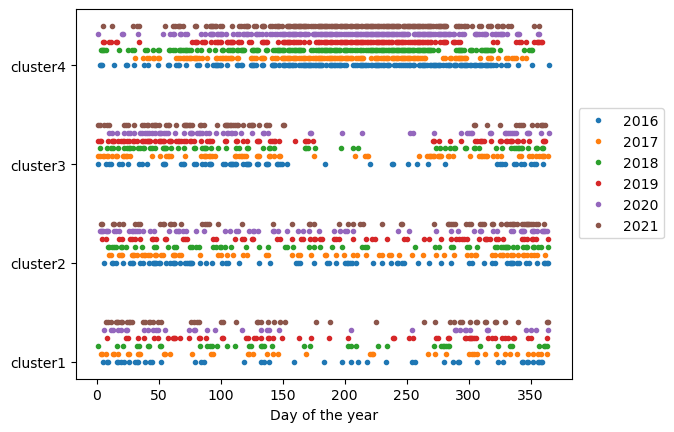

In [75]:
### find the julian day and year for each point in the dataset
fool=selectdf['day'].values

jday = [int(dt.datetime.strptime(date, '%Y-%m-%d').strftime('%j')) for date in fool]
#print(jday)
year = [int(dt.datetime.strptime(date, '%Y-%m-%d').strftime('%Y')) for date in fool]
#print(year)

### find the minimum and maximum index of the array for each year
idx_min=[]
idx_max=[]

for yearSEL in np.arange(2016,2022,1):
  #print(yearSEL)
  yearidx=[index for index,value in enumerate(year) if value==yearSEL]
  idx_min.append(min(yearidx))
  idx_max.append(max(yearidx))

### plot all years
for y in np.arange(0,6,1):
  plt.plot(jday[np.min(idx_min[y]):np.max(idx_max[y])],idx[np.min(idx_min[y]):np.max(idx_max[y])]+0.08*y,'.',\
           label=str(y+2016));

plt.xlabel('Day of the year');
plt.legend(bbox_to_anchor=(1, 0.75), loc='upper left', ncol=1);
plt.yticks(np.arange(1,NO_CLUSTERS+1),labels=['cluster1','cluster2','cluster3','cluster4']);

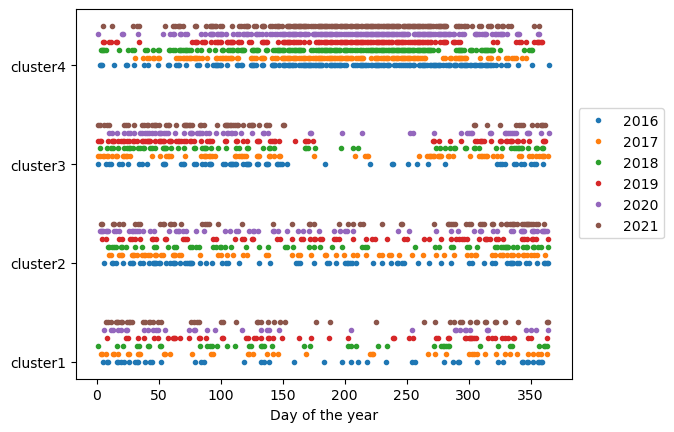

In [76]:
#### here's an even simpler way to code it :).  Whoo!!

### find the julian day and year for each point in the dataset
jday = pd.DatetimeIndex(selectdf['day']).day_of_year
year = pd.DatetimeIndex(selectdf['day']).year

### find the minimum and maximum index of the array for each year
idx_min=[]
idx_max=[]

for yearSEL in np.arange(2016,2022,1):
  #print(yearSEL)
  yearidx=[index for index,value in enumerate(year) if value==yearSEL]
  idx_min.append(min(yearidx))
  idx_max.append(max(yearidx))

### plot all years
for y in np.arange(0,6,1):
  plt.plot(jday[np.min(idx_min[y]):np.max(idx_max[y])],idx[np.min(idx_min[y]):np.max(idx_max[y])]+0.08*y,'.',\
           label=str(y+2016));

plt.xlabel('Day of the year');
plt.legend(bbox_to_anchor=(1, 0.75), loc='upper left', ncol=1);
plt.yticks(np.arange(1,NO_CLUSTERS+1),labels=['cluster1','cluster2','cluster3','cluster4']);

**Plotting methods aside: What does this plot showing? What have you learned about the seasonal occurrence of the different clusters by looking at it? What questions do you have next for plotting?**

**STEP 10: Visualize your results - PART 2 (x-y scatter plots)**.  

*Now for some more visualizing of your result with x-y scatter plots - Why are they helpful?  What do you you learn that is new to you by making these plots?*

plotting these variables: ['tdry_degC', 'wspd_m_per_s']


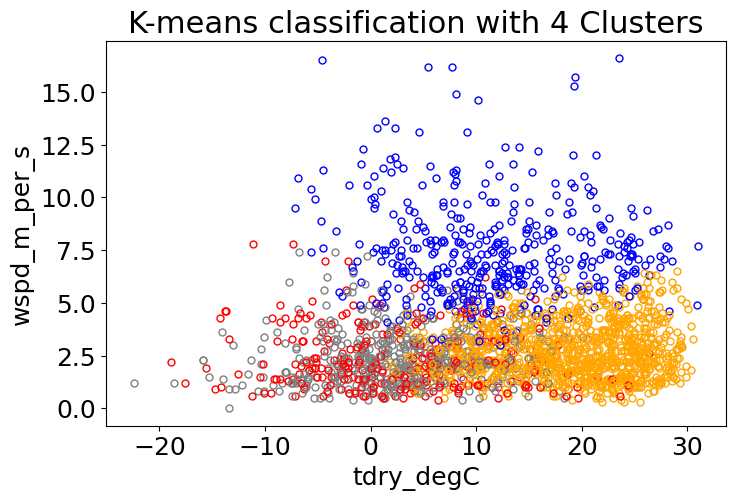

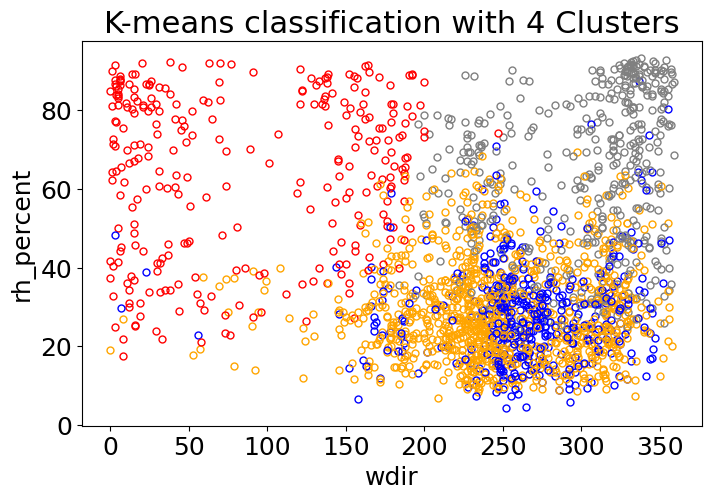

In [77]:
## Create a few xy scatter plots, where points are colored by "season" (from clustering algorithm).

### Pick any two variables that are a part of included_cols
### ['pres_mb','tdry_degC','rh_percent','wdir','wspd_m_per_s','wspdmax_m_per_s','raina_event_mm'] 
##print(included_cols)

##### PLOT #1

### select two variables and put them in vars2plot - # format (x, y)
vars2plot = ['tdry_degC','wspd_m_per_s']
print(f'plotting these variables: {vars2plot}')

data2plot = [data[:,included_cols.index(var)] for var in vars2plot]

## find the integer index of the variable to plot
varidx2plot = np.zeros(2,dtype="int")
for i in np.arange(0,2):
  #print(vars2plot[i])
  varidx2plot[i] = included_cols.index(vars2plot[i])
#print(varidx2plot)

### Next plot these variables as the original valueswith colors to identify the associated cluster
# (red=1, blue=2, grey=3, orange=4)
cols = ['','red','blue','grey','orange']
plt.figure(figsize=(8,5))
plt.title('K-means classification with ' + str(NO_CLUSTERS) + ' Clusters',fontsize=22)
for (ind,val) in enumerate(np.transpose(data2plot)):
    plt.plot(val[0],val[1],".", color=cols[idx[ind]], markersize=10, markerfacecolor = 'none')
    
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(vars2plot[0],fontsize=18);
plt.ylabel(vars2plot[1],fontsize=18);
plt.show()

### You can also plot these variables as scaled values with the cluster centers
#plt.figure(figsize=(8,5))
#plt.title('K-means classification with ' + str(NO_CLUSTERS) + ' Clusters',fontsize=22)
##plt.scatter(scaled_data[:, varidx2plot[0]], scaled_data[:, varidx2plot[1]])
#plt.scatter(centroids[:, varidx2plot[0]], centroids[:, varidx2plot[1]],color='red',marker='*',s=1000)
#plt.xticks(fontsize=18)
#plt.yticks(fontsize=18)
#plt.xlabel('scaled '+vars2plot[0],fontsize=18);
#plt.ylabel('scaled '+vars2plot[1],fontsize=18);
#plt.show()

##### PLOT #2

### select two variables and put them in vars2plot - # format (x, y)
vars2plot = ['wdir','rh_percent']
#print(f'plotting these variables: {vars2plot}')

data2plot = [data[:,included_cols.index(var)] for var in vars2plot]

## find the integer index of the variable to plot
varidx2plot=np.zeros(2,dtype="int")
for i in np.arange(0,2):
  varidx2plot[i]=included_cols.index(vars2plot[i])

### Now plot these variables as the original valueswith colors to identify the associated cluster
# (red=1, blue=2, grey=3, orange=4)
cols = ['','red','blue','grey','orange']
plt.figure(figsize=(8,5))
plt.title('K-means classification with ' + str(NO_CLUSTERS) + ' Clusters',fontsize=22)
for (ind,val) in enumerate(np.transpose(data2plot)):
    plt.plot(val[0],val[1],".", color=cols[idx[ind]], markersize=10, markerfacecolor = 'none')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(vars2plot[0],fontsize=18);
plt.ylabel(vars2plot[1],fontsize=18);

### You can also plot these variables as scaled values with the cluster centers
#plt.figure(figsize=(8,5))
#plt.title('K-means classification with ' + str(NO_CLUSTERS) + ' Clusters',fontsize=22)
##plt.scatter(scaled_data[:, varidx2plot[0]], scaled_data[:, varidx2plot[1]])
#plt.scatter(centroids[:, varidx2plot[0]], centroids[:, varidx2plot[1]],color='red',marker='*',s=1000)
#plt.xticks(fontsize=18)
#plt.yticks(fontsize=18)
#plt.xlabel('scaled '+vars2plot[0],fontsize=18);
#plt.ylabel('scaled '+vars2plot[1],fontsize=18);
#plt.show()

plotting these variables: ['wdir', 'tdry_degC', 'rh_percent']
3
wdir
tdry_degC
rh_percent
[3 1 2]


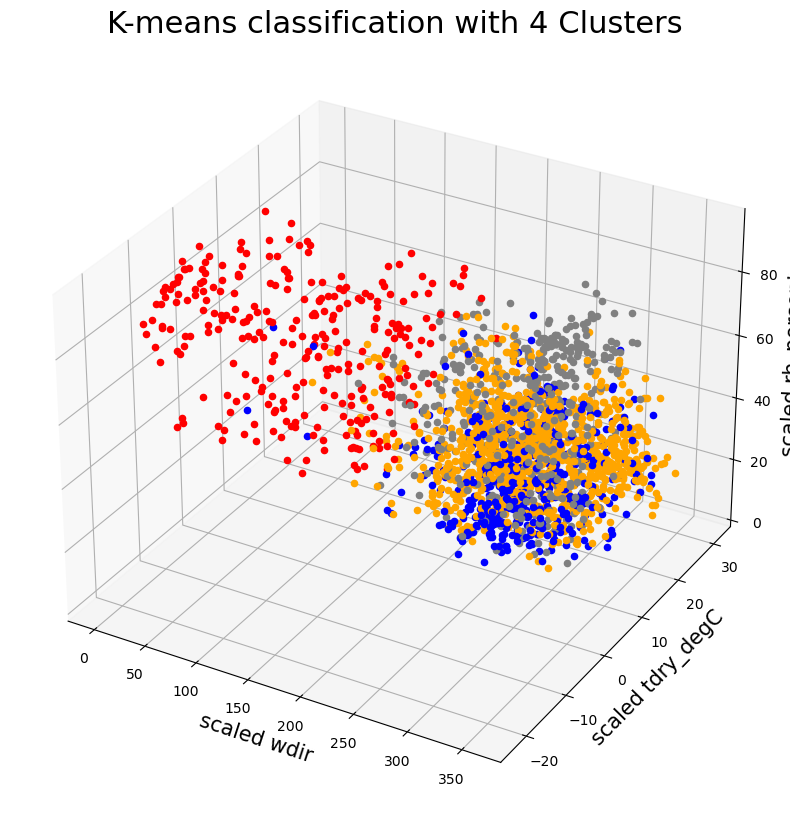

In [78]:
### select THREE variables and put them in vars2plot - # format (x, y, z)
vars2plot = ['wdir','tdry_degC','rh_percent']
print(f'plotting these variables: {vars2plot}')

data2plot = [data[:,included_cols.index(var)] for var in vars2plot]
print(len(data2plot))

## find the integer index of the variable to plot
varidx2plot=np.zeros(3,dtype="int")
for i in np.arange(0,3):
  print(vars2plot[i])
  varidx2plot[i]=included_cols.index(vars2plot[i])
print(varidx2plot)

### Next plot these variables as the original valueswith colors to identify the associated cluster
# (red=1, blue=2, grey=3, orange=4)
cols = ['','red','blue','grey','orange']
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(projection='3d')
ax.set_title('K-means classification with ' + str(NO_CLUSTERS) + ' Clusters',fontsize=22)
for (ind,val) in enumerate(np.transpose(data2plot)):
    ax.scatter(val[0],val[1],val[2],".", color=cols[idx[ind]])
ax.set_xlabel('scaled '+vars2plot[0],fontsize=15);
ax.set_ylabel('scaled '+vars2plot[1],fontsize=15);
ax.set_zlabel('scaled '+vars2plot[2],fontsize=15);
plt.show()

Based on your scatter plots above - When do the variables help (or NOT help) define the clusters?

**STEP 11: Visualize your results - PART 3 (histograms of the assigned clusters in the month-based seasons)**.  

In [79]:
#### prepare data to plot in the histograms

## this is the actual season from the definition in the season dictionary above
season_idx=df['season'][df.hour_UTC==selectedhourUTC].to_numpy()
print(season_idx.shape)

## this is the season from the k-means clustering algorithm
print(idx.shape)

### find what the k-means clustering assigned in each season

## find all of the days in winter, i.e., where season_idx=1
winteridx=np.nonzero(np.where(season_idx==1,1,0))
#print(winteridx) ### uncomment me to check the code
## find what values the k-means classified for this season
winter=idx[winteridx]
#print(winter)  ### uncomment me to check the code

## find all of the days in spring, i.e., where season_idx=2
springidx=np.nonzero(np.where(season_idx==2,1,0))
## find what values the k-means classified for this season
spring=idx[springidx]

## find all of the days in summer, i.e., where season_idx=3
summeridx=np.nonzero(np.where(season_idx==3,1,0))
## find what values the k-means classified for this season
summer=idx[summeridx]

## find all of the days in fall, i.e., where season_idx=4
fallidx=np.nonzero(np.where(season_idx==4,1,0))
## find what values the k-means classified for this season
fall=idx[fallidx]

(2190,)
(2190,)


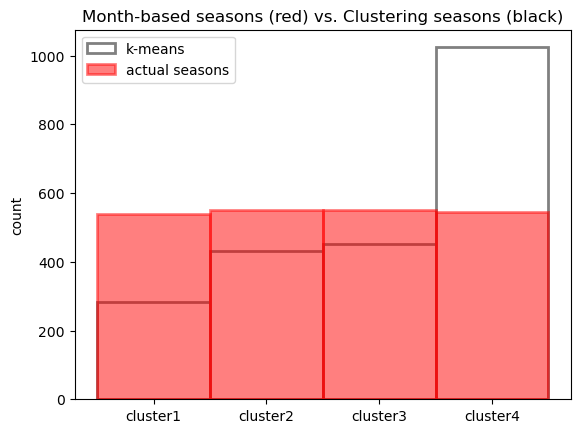

In [80]:
### Histogram Type #1 - Compare seasons based on month and based on k-means clustering over the entire year

## define bins for the histogram
delta= 1                               ## bin size
minbin= 0.5                             ## minimum bin value
maxbin= 5.5                              ## maximum bin value
hist_bins = np.arange(minbin,maxbin,delta) ## bins
#print(hist_bins) ## print your histograms to check them

#### all data - plot the histogram
h, mids = np.histogram(idx,bins=hist_bins);
plt.hist(idx,bins=mids,facecolor='white',edgecolor="grey",label='k-means',lw=2);
plt.hist(season_idx,bins=mids,facecolor='r',edgecolor="r",label='actual seasons',alpha=0.5,lw=2);
plt.ylabel('count')
#plt.ylim(0,1000)
plt.xticks(np.arange(1,4+1),labels=['cluster1','cluster2','cluster3','cluster4']);
plt.legend();
plt.title('Month-based seasons (red) vs. Clustering seasons (black)');

/var/folders/1x/czp6svl93yj38sf90h5yfn5m0000gn/T/ipykernel_20473/4008292391.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(labels4xaxis);
/var/folders/1x/czp6svl93yj38sf90h5yfn5m0000gn/T/ipykernel_20473/4008292391.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(labels4xaxis);


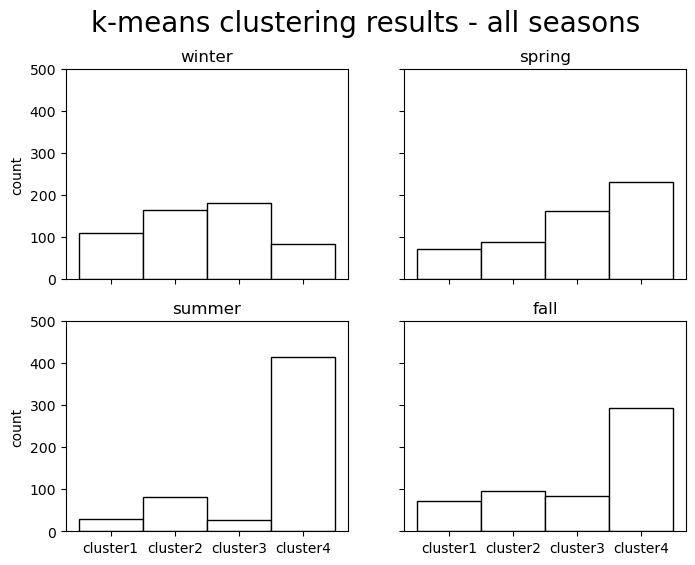

In [83]:
### Histogram Type #2 - Histograms of seasons based on k-means clustering for each season

## define bins for the histogram
delta= 1                               ## bin size
minbin= 0.5                             ## minimum bin value
maxbin= 5.5                              ## maximum bin value
hist_bins = np.arange(minbin,maxbin,delta) ## bins
#print(hist_bins) ## print your histograms to check them

## sanity check = plot the histogram of assigned clusters for winter
#h, mids = np.histogram(winter,bins=hist_bins);
#labels4xaxis=['cluster1','cluster2','cluster3','cluster4']
#plt.figure(figsize=(4,4))
#plt.hist(winter,bins=mids,facecolor='w',edgecolor="k");
#plt.xticks(np.arange(1,4+1),labels=labels4xaxis);
#plt.title('Winter');
#plt.show();

### Show all seasons using subplots
### Help with subplots: https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html

labels4xaxis=['','cluster1','cluster2','cluster3','cluster4']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('k-means clustering results - all seasons',fontsize=20)
fig.set_figheight(6)
fig.set_figwidth(8)

ymax=500
h, mids = np.histogram(winter,bins=hist_bins);
ax1.hist(winter,bins=mids,facecolor='w',edgecolor="k");
ax1.set_title("winter");
ax1.set_ylabel("count");
ax1.set_ylim(0,ymax)
h, mids = np.histogram(spring,bins=hist_bins);
ax2.hist(spring,bins=mids,facecolor='w',edgecolor="k");
ax2.set_title("spring");
ax2.set_ylim(0,ymax)
h, mids = np.histogram(summer,bins=hist_bins);
ax3.hist(summer,bins=mids,facecolor='w',edgecolor="k");
ax3.set_title("summer");
ax3.set_xticklabels(labels4xaxis);
ax3.set_ylabel("count");
ax3.set_ylim(0,ymax)
h, mids = np.histogram(fall,bins=hist_bins);
ax4.hist(fall,bins=mids,facecolor='w',edgecolor="k");
ax4.set_title("fall");
ax4.set_xticklabels(labels4xaxis);
ax4.set_ylim(0,ymax)

for ax in fig.get_axes():
    ax.label_outer()

**Based on your plots histograms plotted by season - What clusters are happening in what seasons?  When you use 4 clusters - do they align with our definitions of "winter", "summer", "spring", "fall" based on month of the year?  Why or why not?**

In [84]:
### Add cluster to the data frame and print the values for a given date range

### for example you might want to print the days around Labor Day in 2020
### these are the days we talked about in the introduction to the application lab...
startdate='2020-09-04'
enddate='2020-09-11'

### or the end of 2021..
#startdate='2021-12-01'
#enddate='2021-12-31'

foo=selectdf.copy()
foo['cluster']=idx

#print(foo[(foo['day'] > startdate) & (foo['day'] < '2020-09-10')][enddate]);
#print(foo[(foo['day'] > startdate) & (foo['day'] < '2020-09-10')][enddate]);

foo[(foo['day'] > startdate) & (foo['day'] < enddate)]

,day,hour_UTC,pres_mb,tdry_degC,rh_percent,wdir,wspd_m_per_s,wspdmax_m_per_s,raina_event_mm,year,season,cluster
40970,2020-09-05,2.0,819.700012,25.0,18.900000,250.0,1.7,2.8,0.0,2020,4,4
40994,2020-09-06,2.0,816.400024,30.1,11.300000,316.0,4.7,6.8,0.0,2020,4,4
41018,2020-09-07,2.0,813.900024,28.4,9.800000,234.0,3.2,4.8,0.0,2020,4,4
41042,2020-09-08,2.0,809.000000,16.9,46.099998,336.0,9.3,15.4,0.0,2020,4,2
41066,2020-09-09,2.0,818.200012,-1.7,89.699997,329.0,6.4,10.1,0.0,2020,4,3
41090,2020-09-10,2.0,819.400024,1.0,83.500000,137.0,1.2,1.7,0.0,2020,4,1


**What do the clusters show during the time period from September 5-15, 2020 (Labor Day 2020)?  Are the cluster assignments consistent with the weather experienced over that time period?**